## Interface height vs layer thickness gradients

In models with large scale bottom slope changes the bottom layer thickness ends up incorporating this information in it. While this bottom slope probably impacts the eddy fluxes, it does not seem to be the case that this has a first order effect. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-04 11:04:51.891927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 11:04:51.891952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 11:04:51.893363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We will run a few experiment configs. All with non-dim outputs. The goal is to compare the impact of inputs.

1. Inputs: norm vel gradients, thickness gradients
2. Inputs: norm vel gradients, interface slope
3. Inputs: norm vel gradients, thickness gradients, inteface slopes

In [4]:
# Experiment
experiment_config_1= {'simulation_names':['P2L'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':1, 
                    
                    'input_channels' : ['dudx',  
                                        'dvdx', 
                                        'dudy',
                                        'dvdy',
                                        'dhdx',
                                        'dhdy',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 
        
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    'num_inputs': 7, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt'
                    
            }

experiment_config_1['all_ml_variables'] = (experiment_config_1['input_channels'] + 
                                           experiment_config_1['output_channels'] +
                                           experiment_config_1['coeff_channels'])

In [45]:
# Experiment
experiment_config_2= {'simulation_names':['P2L'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':1, 
                    
                    'input_channels' : ['dudx',  
                                        'dvdx', 
                                        'dudy',
                                        'dvdy',
                                        'dhdx',
                                        'dhdy',
                                        'dedx_middle',
                                        'dedy_middle',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 
        
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    'num_inputs': 9, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt'
                    
            }

experiment_config_2['all_ml_variables'] = (experiment_config_2['input_channels'] + 
                                           experiment_config_2['output_channels'] +
                                           experiment_config_2['coeff_channels'])

In [46]:
experiment_config = experiment_config_2

In [37]:

#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'])

ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 0.2112 gb into memory.
load took: 9.0578 seconds
Will load : 0.02112 gb into memory.
load took: 1.0417 seconds


In [38]:
batch_xr = ML_DT_train.ml_batches[0]

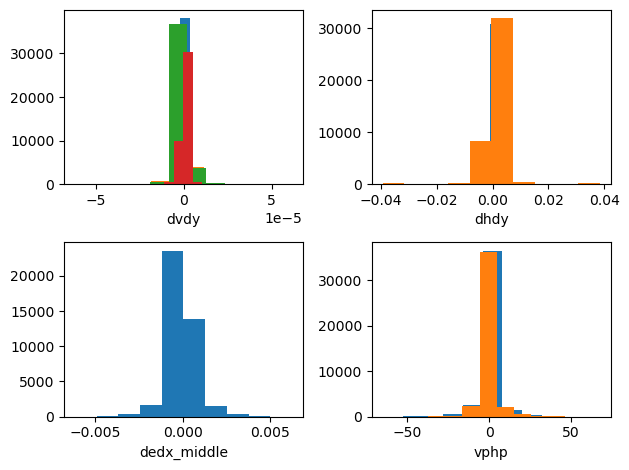

In [39]:
plt.subplot(221)
batch_xr[experiment_config['input_channels'][0]].plot.hist();
batch_xr[experiment_config['input_channels'][1]].plot.hist();
batch_xr[experiment_config['input_channels'][2]].plot.hist();
batch_xr[experiment_config['input_channels'][3]].plot.hist();

plt.subplot(222)
batch_xr[experiment_config['input_channels'][4]].plot.hist();
batch_xr[experiment_config['input_channels'][5]].plot.hist();

plt.subplot(223)
batch_xr[experiment_config['input_channels'][6]].plot.hist();

plt.subplot(224)
batch_xr[experiment_config['output_channels'][0]].plot.hist();
batch_xr[experiment_config['output_channels'][1]].plot.hist();

plt.tight_layout()

In [40]:
batch_xr.std()

<xarray.Dataset> Size: 80B
Dimensions:       ()
Data variables:
    dudx          float64 8B 1.868e-06
    dvdx          float64 8B 3.359e-06
    dudy          float64 8B 3.209e-06
    dvdy          float64 8B 1.858e-06
    dhdx          float64 8B 0.000782
    dhdy          float64 8B 0.004339
    dedx_middle   float64 8B 0.0007811
    dedy_middle   float64 8B 0.004317
    filter_scale  float64 8B 1.347e+05
    uphp          float32 4B 5.408
    vphp          float32 4B 4.958

In [41]:
# Define the variables and assign normalizations 

normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'dedx_middle': ([], 1e-3),
    'dedy_middle': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),

    'dudx_nondim': ([], 1.),  # scalar value
    'dvdx_nondim': ([], 1.),
    'dudy_nondim': ([], 1.),
    'dvdy_nondim': ([], 1.),
    
    'uphp_nondim': ([], 1e-5),
    'vphp_nondim': ([], 1e-5),

    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
    'dhdx_widened_rotated': ([], 1e-3),
    'dhdy_widened_rotated': ([], 1e-3),
    
    'dudx_widened_rotated_nondim': ([], 1e-1),  # scalar value
    'dvdx_widened_rotated_nondim': ([], 1e-1),
    'dudy_widened_rotated_nondim': ([], 1e-1),
    'dvdy_widened_rotated_nondim': ([], 1e-1),
    'dhdx_widened_rotated_nondim': ([], 1e-1),
    'dhdy_widened_rotated_nondim': ([], 1e-1),
    'uphp_rotated_nondim': ([], 1e-5),
    'vphp_rotated_nondim': ([], 1e-5),
}

ds_norm = xr.Dataset(normalize_data_dic)

In [42]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [43]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (41513, 9)
Output (y) batch shape: (41513, 2)


In [44]:
num_in = batch_out['X'].shape[-1]
num_in

9

In [47]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [48]:
ANN_model.count_parameters()

1766


In [49]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [50]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=41, print_freq=2)

At epoch 1. Train loss :  1.4406546322075096 , Test loss: 0.9780000925064087
At epoch 3. Train loss :  0.5715209567869032 , Test loss: 0.4591958403587341
At epoch 5. Train loss :  0.3736415521518604 , Test loss: 0.3167180955410004
At epoch 7. Train loss :  0.2967399584280478 , Test loss: 0.264542019367218
At epoch 9. Train loss :  0.2687903723201236 , Test loss: 0.24075506031513214
At epoch 11. Train loss :  0.2525399407824954 , Test loss: 0.22849246859550476
At epoch 13. Train loss :  0.24352779662286914 , Test loss: 0.22104639708995819
At epoch 15. Train loss :  0.23702831485786954 , Test loss: 0.21603043675422667
At epoch 17. Train loss :  0.23185231677583745 , Test loss: 0.21215274333953857
At epoch 19. Train loss :  0.2280022079074705 , Test loss: 0.2081925928592682
At epoch 21. Train loss :  0.22483707199225555 , Test loss: 0.20544061362743377
At epoch 23. Train loss :  0.22206287206830205 , Test loss: 0.20236778259277344
At epoch 25. Train loss :  0.21939967129681562 , Test loss

In [51]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

### Model evaluation 

In [52]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'])


In [53]:
test_eval.read_ann_regression_model()
test_eval.read_eval_data()
test_eval.predict()

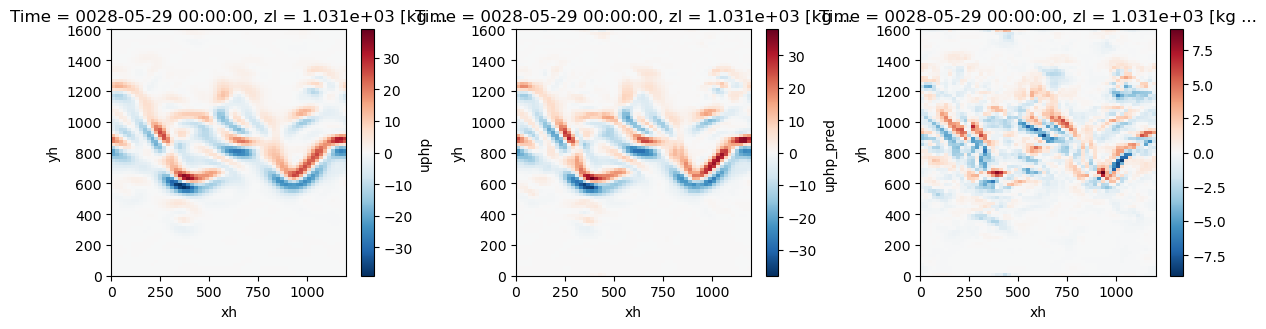

In [54]:
plt.figure(figsize=(12, 3.4))

plt.subplot(131)
test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=0).plot()

plt.subplot(132)
test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=0).plot()

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=0).plot()

plt.tight_layout()

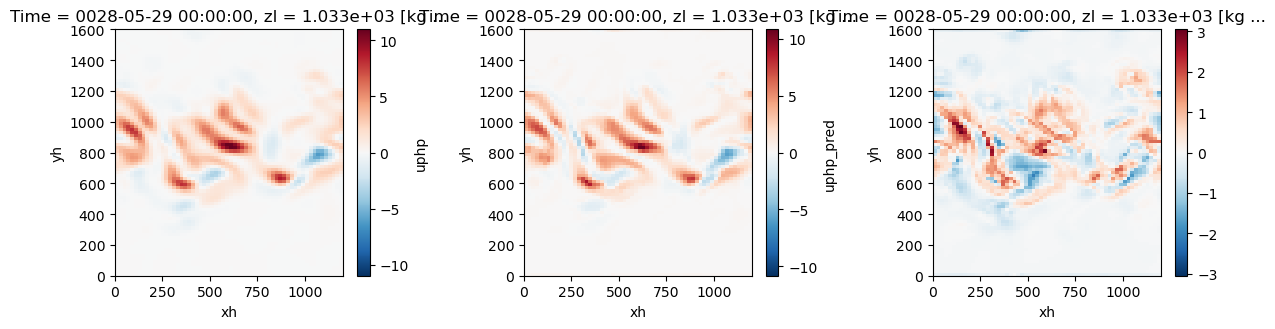

In [55]:
plt.figure(figsize=(12, 3.4))
zl_choice = 1

plt.subplot(131)
test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot()

plt.subplot(132)
test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot()

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset['P2L']['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot()

plt.tight_layout()

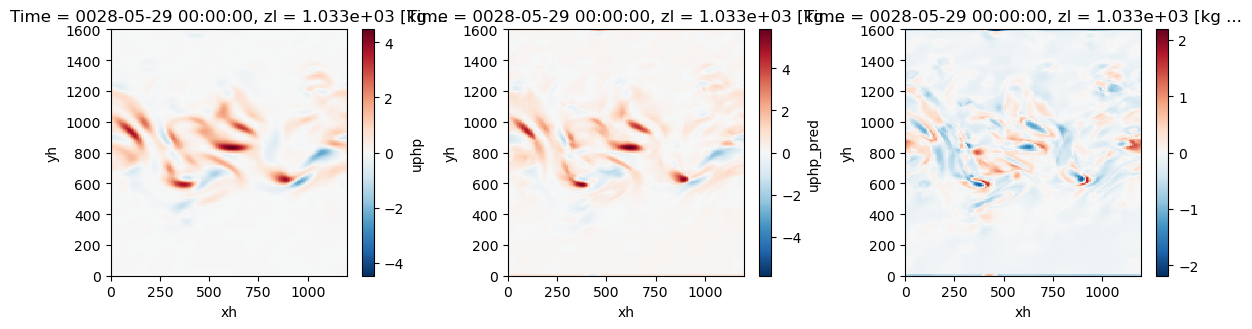

In [56]:
plt.figure(figsize=(12, 3.4))
zl_choice = 1
scale = '50'

plt.subplot(131)
test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot()

plt.subplot(132)
test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot()

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot()

plt.tight_layout()

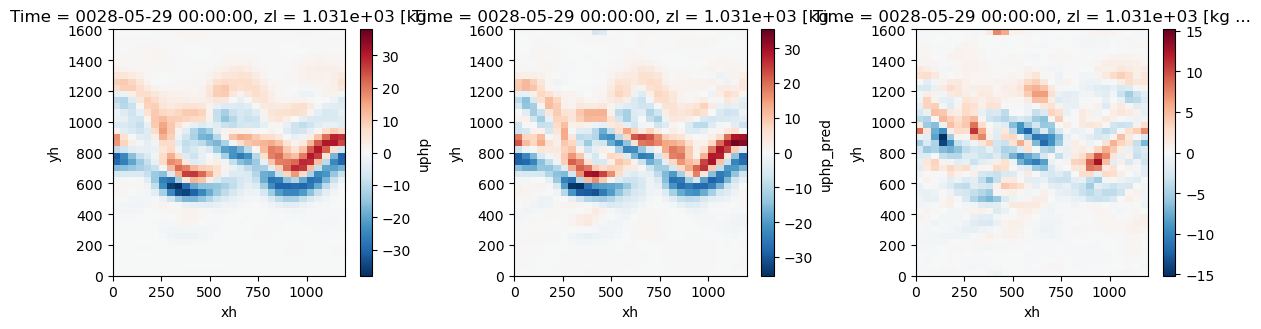

In [57]:
plt.figure(figsize=(12, 3.4))
zl_choice = 0
scale = '200'

plt.subplot(131)
test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot()

plt.subplot(132)
test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot()

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot()

plt.tight_layout()

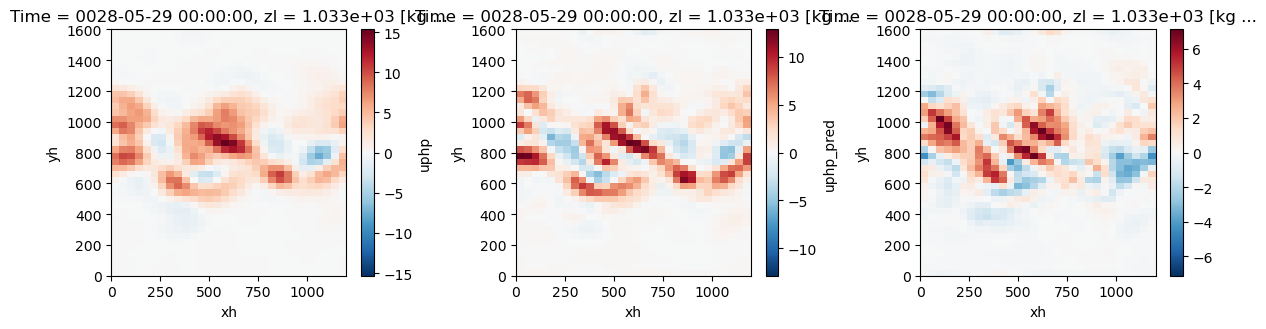

In [58]:
plt.figure(figsize=(12, 3.4))
zl_choice = 1
scale = '200'

plt.subplot(131)
test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot()

plt.subplot(132)
test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot()

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot()

plt.tight_layout()

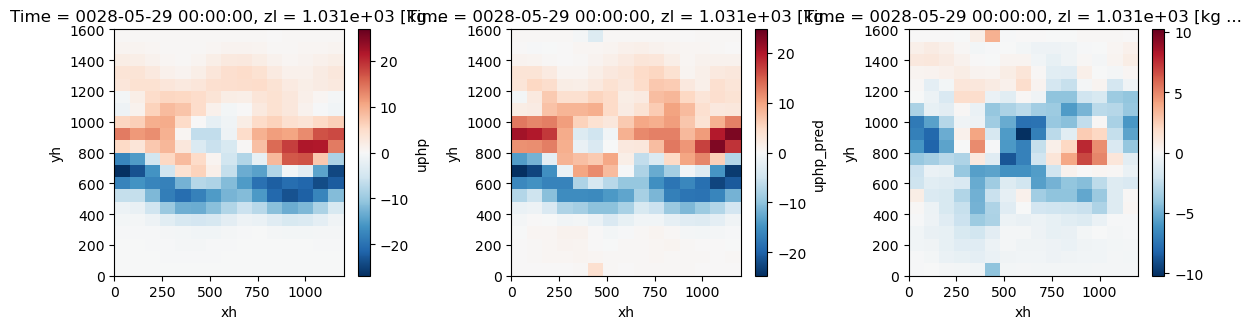

In [59]:
plt.figure(figsize=(12, 3.4))
zl_choice = 0
scale = '400'

plt.subplot(131)
test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot()

plt.subplot(132)
test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot()

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot()

plt.tight_layout()

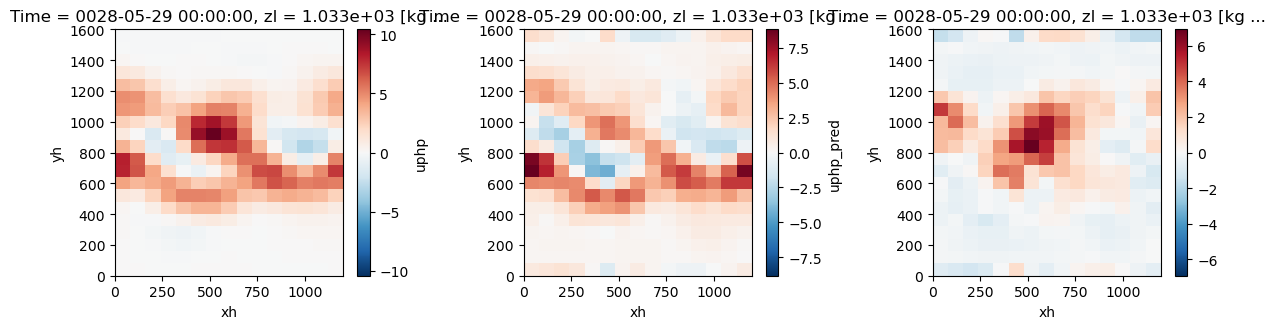

In [60]:
plt.figure(figsize=(12, 3.4))
zl_choice = 1
scale = '400'

plt.subplot(131)
test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot()

plt.subplot(132)
test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot()

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset['P2L'][scale][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot()

plt.tight_layout()